In [1]:
import torch
import torch.nn as nn
from datasets import UnderwaterCreaturesMultiLabelDataset, collate_fn
from torch.utils.data import DataLoader
from models import SimpleCNN
from trainer import Trainer

/home/ubuntu/micromamba/envs/deepl/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Root directory of the dataset
class_names = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
num_classes = len(class_names)
root_dir = 'aquarium-data-cots/aquarium_pretrain'

# Create datasets
train_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='train', num_classes=num_classes)
valid_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='valid', num_classes=num_classes)
test_dataset = UnderwaterCreaturesMultiLabelDataset(root_dir, split='test', num_classes=num_classes)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [5]:
# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN(num_classes=len(class_names))
model = model.to(device)

# Define loss function and optimizer
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/5, Training Loss: 0.4766
Validation Loss: 0.4221
Epoch 2/5, Training Loss: 0.4013
Validation Loss: 0.3727
Epoch 3/5, Training Loss: 0.3509
Validation Loss: 0.3381
Epoch 4/5, Training Loss: 0.3263
Validation Loss: 0.3304
Epoch 5/5, Training Loss: 0.3097
Validation Loss: 0.3156


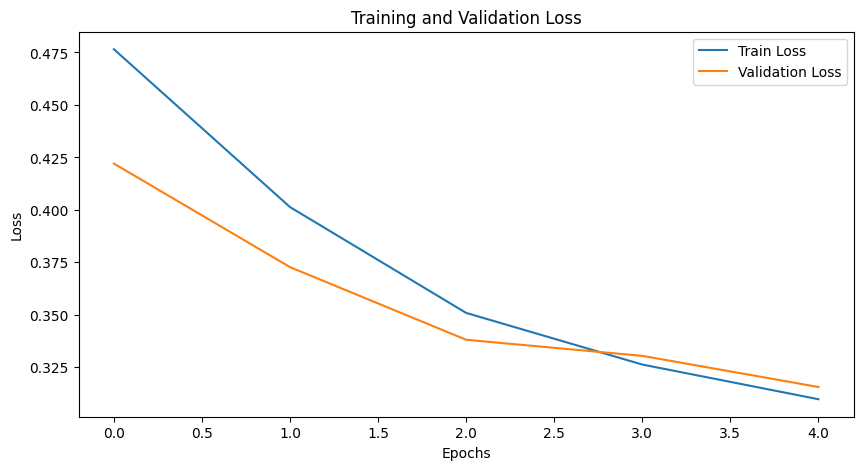

Class fish AP: 0.7492
Class jellyfish AP: 0.6534
Class penguin AP: 0.6797
Class puffin AP: 0.5806
Class shark AP: 0.6566
Class starfish AP: 0.5392
Class stingray AP: 0.5480
mAP: 0.6295


In [6]:
# Initialize the Trainer
trainer = Trainer(model, device, criterion, optimizer, num_classes=len(class_names), class_names=class_names)
# Train the model
num_epochs = 5
trainer.train(train_loader, valid_loader, num_epochs=num_epochs)
# Plot training metrics
trainer.plot_metrics()
# Test the model
# Evaluate metrics on validation set
val_targets, val_outputs, average_precisions, mAP = trainer.evaluate_metrics(valid_loader)

In [ ]:
# Plot ROC curves for validation set
trainer.plot_roc_curves(val_targets, val_outputs)
# Plot confusion matrices for validation set
trainer.plot_confusion_matrices(val_targets, val_outputs, threshold=0.5)


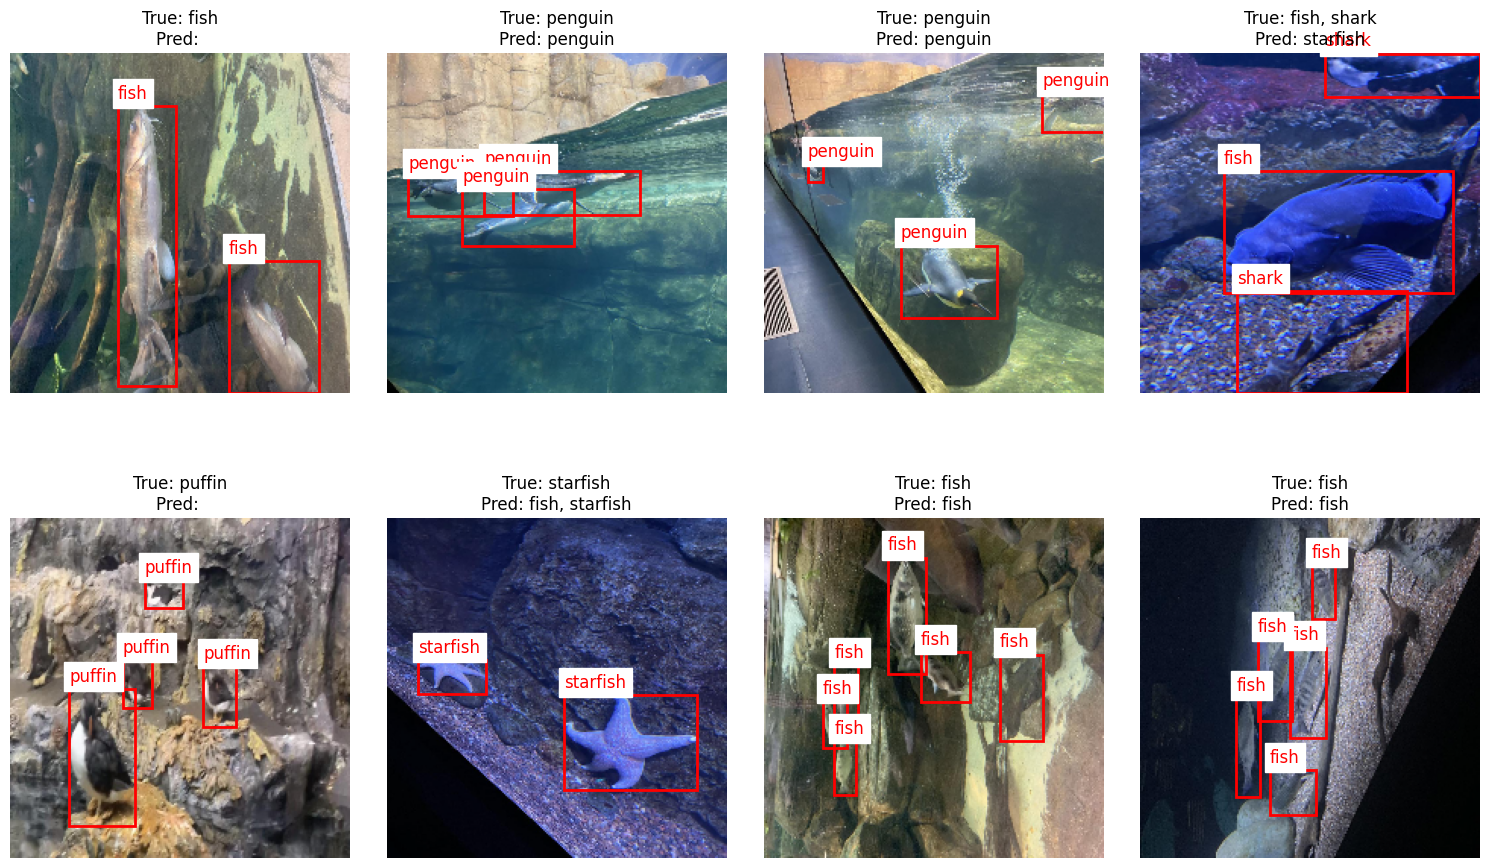

In [ ]:
# Visualize predictions on validation set
trainer.visualize_predictions(valid_loader, num_images=8, threshold=0.8)


# Test set

In [4]:
# Evaluate metrics on test set
test_targets, test_outputs, test_average_precisions, test_mAP = trainer.evaluate_metrics(test_loader)

# Plot ROC curves for test set
trainer.plot_roc_curves(test_targets, test_outputs)

# Plot confusion matrices for test set
trainer.plot_confusion_matrices(test_targets, test_outputs, threshold=0.5)

# Visualize predictions on test set
trainer.visualize_predictions(test_loader, num_images=8, threshold=0.7)

NameError: name 'trainer' is not defined